# Relationship between age and income

The goal is to investigate the relationship between age and income using US census data. The target of inference is the linear regression coefficient when regressing yearly income in dollars on age, while controlling for sex. The data from California in the year 2019 is downloaded through the Folktables interface (1). Predictions of income are made by training a gradient boosting tree via XGBoost (2) on the previous year’s data.

1. F. Ding, M. Hardt, J. Miller, L. Schmidt, “Retiring adult: New datasets for fair machine learning” in Advances in Neural Information Processing Systems 34 (2021), pp. 6478–6490.
2. T. Chen, C. Guestrin, “XGBoost: A scalable tree boosting system” in Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (2016), pp. 785–794.

### Import necessary packages

In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_ci, classical_ols_ci
from statsmodels.regression.linear_model import OLS
from scipy.optimize import brentq
from tqdm import tqdm
from utils import *

### Import the census income data set

Load the data. The data set contains reported income (```Y```), predicted income (```Yhat```), and age and sex (```X```).

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

### Diagnostic Check

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_with_const = sm.add_constant(X_total)
model = sm.OLS(Y_total, X_with_const).fit()

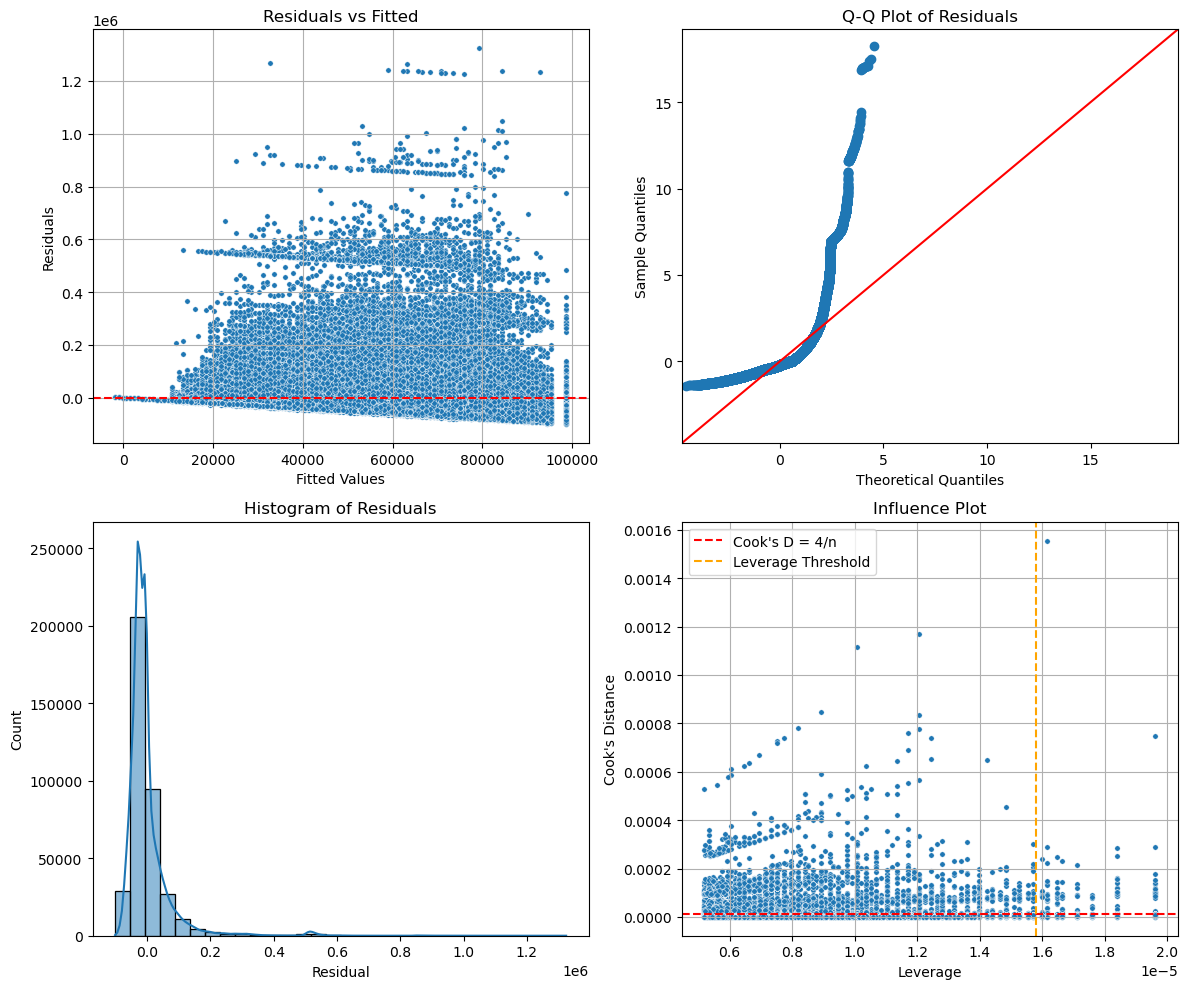

Potential influential points (index): [    12    154    181 ... 379985 380058 380081]


<Figure size 640x480 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import numpy as np


fitted = model.fittedvalues
residuals = model.resid


influence = model.get_influence()
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]
n, p = X_total.shape
leverage_threshold = 2 * (p + 1) / n

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
sns.scatterplot(x=fitted, y=residuals, s=15, ax=axes[0, 0])
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title("Residuals vs Fitted")
axes[0, 0].set_xlabel("Fitted Values")
axes[0, 0].set_ylabel("Residuals")
axes[0, 0].grid(True)

# 2. QQ Plot
qqplot(residuals, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title("Q-Q Plot of Residuals")

# 3. Histogram of Residuals
sns.histplot(residuals, kde=True, bins=30, ax=axes[1, 0])
axes[1, 0].set_title("Histogram of Residuals")
axes[1, 0].set_xlabel("Residual")

# 4. Leverage vs Cook's Distance
sns.scatterplot(x=leverage, y=cooks_d, s=15, ax=axes[1, 1])
axes[1, 1].axhline(4 / n, color='red', linestyle='--', label="Cook's D = 4/n")
axes[1, 1].axvline(leverage_threshold, color='orange', linestyle='--', label="Leverage Threshold")
axes[1, 1].set_title("Influence Plot")
axes[1, 1].set_xlabel("Leverage")
axes[1, 1].set_ylabel("Cook's Distance")
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
plt.savefig("diagnostic.png")

influential_points = np.where((leverage > leverage_threshold) | (cooks_d > 4 / n))[0]
print("Potential influential points (index):", influential_points)

In [ ]:
#3. Variance Inflation Factor (VIF)
vif_df = pd.DataFrame()
vif_df["variable"] = [f"X{i}" for i in range(X_total.shape[1])]
vif_df["VIF"] = [variance_inflation_factor(X_with_const, i + 1) for i in range(X_total.shape[1])]  # skip intercept
print(vif_df)

  variable      VIF
0       X0  1.00197
1       X1  1.00197


In [4]:
import numpy as np

def r2_score(Y, Yhat):
    ss_res = np.sum((Y - Yhat) ** 2)
    ss_tot = np.sum((Y - np.mean(Y)) ** 2)
    return 1 - ss_res / ss_tot

R2 = r2_score(Y_total, Yhat_total)
print("R^2 =", R2)

R^2 = 0.3187554107115049


In [6]:
X_total.shape, Y_total.shape, Yhat_total.shape

((380091, 2), (380091,), (380091,))

In [15]:
np.std(Y_total), np.std(Yhat_total),np.mean(Y_total), np.mean(Yhat_total),np.std(X_total, axis=0), np.mean(X_total, axis=0)

(75881.25228785505,
 33520.703,
 43105.58967457793,
 31640.762,
 array([23.28034613,  0.49995412]),
 array([40.8604571 ,  1.50677338]))

In [84]:
Y_total[Y_total < 0] = 0
Yhat_total[Yhat_total < 0] = 0
Y_total2, Yhat_total2 = np.log(Y_total+0.001), np.log(Yhat_total+0.001)

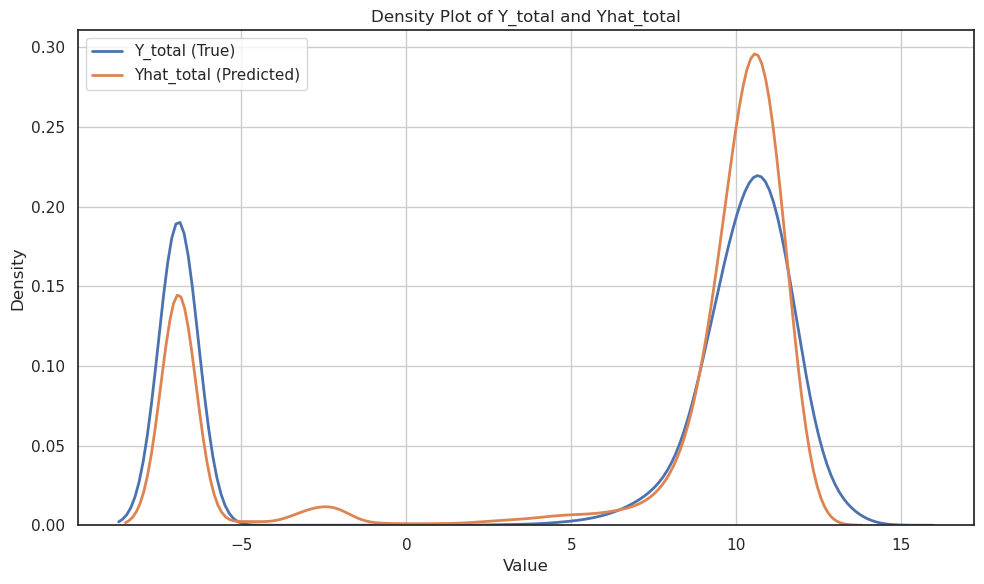

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(Y_total2, label="Y_total (True)", linewidth=2)
sns.kdeplot(Yhat_total2, label="Yhat_total (Predicted)", linewidth=2)
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Density Plot of Y_total and Yhat_total")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [4]:
alpha = 0.05
coordinate = 0  # Choose between 0, 1
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(100, 2000, 10).astype(
    int
)  # Test for different numbers of labeled incomes
num_trials = 100
# Compute ground truth
true_theta = OLS(Y_total, exog=X_total).fit().params[coordinate]
# true_theta2 = OLS(Y_total2, exog=X_total).fit().params[coordinate]

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Imputation```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [5]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = (
            Yhat_total[rand_idx[:n]],
            Yhat_total[rand_idx[n:]],
        )

        ppi_ci, lam = ppi_ols_ci(
            _X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha
        )

        # Classical interval
        classical_ci = classical_ols_ci(_X, _Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0][coordinate],
                        "upper": ppi_ci[1][coordinate],
                        "trial": j,
                        "lambda": lam,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0][coordinate],
                        "upper": classical_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_ols_ci(X_total, Yhat_total, alpha=alpha)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0][coordinate],
                "upper": imputed_ci[1][coordinate],
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|██████████| 10/10 [12:35<00:00, 75.54s/it]


In [8]:
df["lambda"].mean()

0.9370841181999372

In [90]:
# log results
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total2[rand_idx[:n]], Y_total2[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = (
            Yhat_total2[rand_idx[:n]],
            Yhat_total2[rand_idx[n:]],
        )

        ppi_ci = ppi_ols_ci(
            _X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha
        )

        if not ppi_ci[0][coordinate]:
            break

        # Classical interval
        classical_ci = classical_ols_ci(_X, _Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0][coordinate],
                        "upper": ppi_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0][coordinate],
                        "upper": classical_ci[1][coordinate],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_ols_ci(X_total, Yhat_total2, alpha=alpha)
results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0][coordinate],
                "upper": imputed_ci[1][coordinate],
                "trial": 0,
            }
        ]
    )
]

df_log = pd.concat(results, axis=0, ignore_index=True)
df_log["width"] = df_log["upper"] - df_log["lower"]

100%|██████████| 10/10 [22:58<00:00, 137.81s/it]


In [94]:
df_log = df_log[df_log["method"]!= "Imputation"]

### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the classical method, and the imputed interval;
2. The average interval width for PPI and the classical method, together with a scatterplot of the widths from the five random draws.

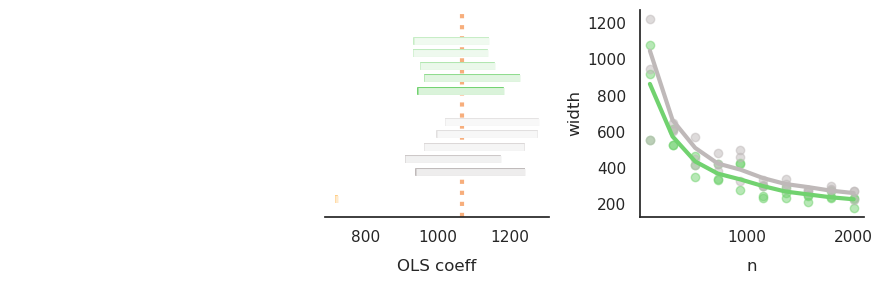

In [103]:
make_plots(
    df,
    "./plots/census_income.pdf",
    intervals_xlabel="OLS coeff",
    true_theta=true_theta,
)

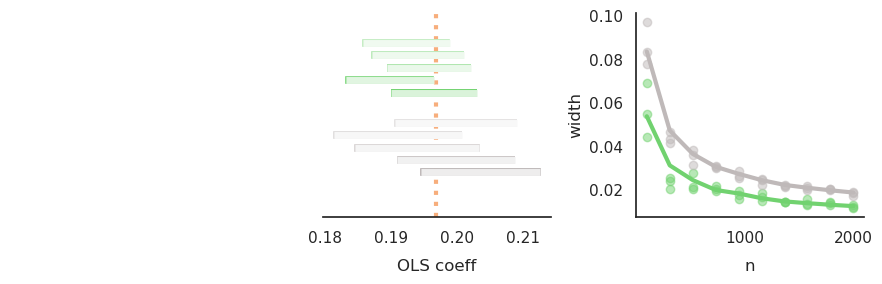

In [104]:
make_plots(
    df_log,
    "./plots/census_income2.pdf",
    intervals_xlabel="OLS coeff",
    true_theta=true_theta2,
)

### Power experiment

For PPI and the classical approach, find the smallest value of ```n``` such that the method has power 80% against the null $H_0: \theta^* < 800$.

In [ ]:
# Find n such that we reject H0: OLS coeff < 800 with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [
    np.random.permutation(n_total) for i in range(num_experiments)
]


def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = (
            Yhat_total[rand_idx[:n]],
            Yhat_total[rand_idx[n:]],
        )

        ppi_ci = ppi_ols_ci(
            _X, _Y, _Yhat, _X_unlabeled, _Yhat_unlabeled, alpha=alpha
        )

        if ppi_ci[0][coordinate] > 800:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _X, _X_unlabeled = X_total[rand_idx[:n]], X_total[rand_idx[n:]]
        _Y, _Y_unlabeled = Y_total[rand_idx[:n]], Y_total[rand_idx[n:]]
        _Yhat, _Yhat_unlabeled = (
            Yhat_total[rand_idx[:n]],
            Yhat_total[rand_idx[n:]],
        )

        classical_ci = classical_ols_ci(_X, _Y, alpha=alpha)

        if classical_ci[0][coordinate] > 800:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [ ]:
n_ppi = int(brentq(_to_invert_ppi, 100, 2000, xtol=1))
n_classical = int(brentq(_to_invert_classical, 100, 2000, xtol=1))
print(
    f"The PPI test requires n={n_ppi} labeled data points to reject the null."
)
print(
    f"The classical test requires n={n_classical} labeled data points to reject the null."
)

The PPI test requires n=555 labeled data points to reject the null.
The classical test requires n=864 labeled data points to reject the null.
